In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [2]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Layer
import tensorflow as tf


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# for directory in os.listdir('data/lfw'):
#     for file in os.listdir(os.path.join('data/lfw', directory)):
#         EX_PATH = os.path.join('data/lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

In [7]:
import uuid

In [8]:
import cv2
import os
import uuid

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0xFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0xFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    if not ret:
        break

    cv2.imshow('image Collection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


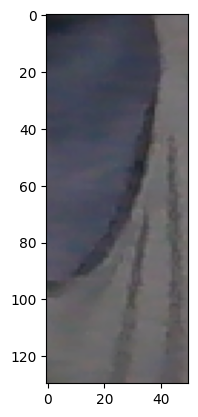

In [9]:
plt.imshow(frame[120:120+250, 200:200+250,:])

In [ ]:
anchor   = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)

In [186]:
dir_test = anchor.as_numpy_iterator()
dir_test = dir_test.next()
print(dir_test)

b'data\\anchor\\2326d555-4c64-11f0-9345-9061ae954920.jpg'


In [187]:
def preprocess(file_path):
    # read a image file
    byte_img = tf.io.read_file(file_path)
    # decode it into tenso with 3 channels (rgb)
    img = tf.image.decode_jpeg(byte_img)
    # preprocessing steps - rsizing the imge to 100*100
    img = tf.image.resize(img,(100,100))
    # scale image to be between 0 and1
    img = img/255.0
    return img


In [188]:
img= preprocess(dir_test)

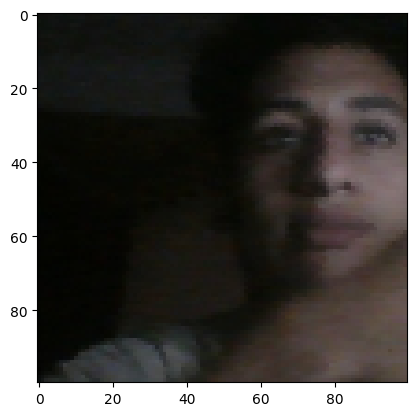

In [189]:
plt.imshow(img)

In [194]:
positives = tf.data.Dataset.zip((anchor, positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [195]:
def preprocess_twin(input_img,validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [196]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [201]:
round(len(data))

600

In [203]:
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [204]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [205]:
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)